The dataset consists of movie reviews with the sentiments being provided. The sentiments are either positive or negative. Used an SVM based classifier to obtain train and check on the sample test dataset provided. The method will be evaluated also against an external test set. It should be possible to automate the testing and hardcoding values does not allow for automated testing. 

#### Process the text and obtain a bag of words-based features 

In [50]:
import numpy as np
import nltk
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
import re,string,unicodedata
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

#Removing the html strips
def strip_html(text):
    cleantext = re.sub(re.compile('<.*?>') , '', text)
    return cleantext

#Removing data in betweenn brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

# Removing special characters and digits.Making lower case
def remove_special_characters(row):
    row = row.lower()
    digits=str.maketrans('','',string.digits)
    punctuation=str.maketrans('','',string.punctuation)    
    row=row.translate(digits).translate(punctuation)
    return row

# Stemming using porter stemmer
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    review=[ps.stem(r) for r in text]
    return review

# Removing stopwords
stop_words = stopwords.words('english')
def remove_stopwords(review):
    review = [r for r in review if (r not in stop_words) and (len(r)>2)]
    review=' '.join(review)
    return review

def pre_process_reviews(train_df, test_df):
    train_df['review'] = train_df['review'].apply(denoise_text)
    test_df['review'] = test_df['review'].apply(denoise_text)
    
    train_df['review'] = train_df['review'].apply(remove_special_characters)
    test_df['review'] = test_df['review'].apply(remove_special_characters)
    
    
    train_df['review'] = train_df['review'].apply(word_tokenize)
    test_df['review'] = test_df['review'].apply(word_tokenize)
    
    train_df['review'] = train_df['review'].apply(simple_stemmer)
    test_df['review']= test_df['review'].apply(simple_stemmer)
    
    train_df['review'] = train_df['review'].apply(remove_stopwords)
    test_df['review'] = test_df['review'].apply(remove_stopwords)
    
    train_df['sentiment'] = train_df['sentiment'].map({'positive': 1, 'negative': -1})
    test_df['sentiment'] = test_df['sentiment'].map({'positive': 1, 'negative': -1})
    
    return train_df,test_df

feature_vector = None
def extract_bag_of_words_train_test(train_file, test_file):
    # Read the CSV file and extract Bag of Words Features
    train_df = pd.read_csv(train_file)
    test_df = pd.read_csv(test_file)
    
    clean_train_df, clean_test_df = pre_process_reviews(train_df, test_df)
     
    #Tfidf vectorizer
    tv = TfidfVectorizer(analyzer='word',lowercase=False)
    #transformed train reviews
    X_train = tv.fit_transform(clean_train_df['review'])
    #transformed test reviews
    X_test = tv.transform(clean_test_df['review'])
    
    Y_train = clean_train_df['sentiment'] 
    
    Y_test = clean_test_df['sentiment']
    
    feature_vector = tv.get_feature_names()
    
    print(X_train.shape, X_test.shape)
    print(Y_train.shape, Y_test.shape)
    return (X_train,Y_train,X_test,Y_test)

In [54]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

# Creating gram matrix for the training data. This is part of the custom kernel
def get_gram_train(x1, x2):
    return (10**np.dot(x1,x2.T))

# Creating gram matrix for the testing data. This is part of the custom kernel too
def get_gram_test(x1,x2):
    return np.dot(x1,x2.T)

class SVMClassifier:
    
    def __init__(self):
        
        import numpy as np
        from sklearn import svm
        from sklearn.svm import SVC
        #implement initialisation
        # define your own kernel here
        # The kernel we use is custom hence the kernel is provided as pre-computed
        sv = SVC(kernel='precomputed')
        self.parameters = {'gamma':[0.01, 0.1, 1, 10]} 
        
        # using Grid Search CV
        self.model = GridSearchCV(sv,self.parameters, cv=5 ,scoring='accuracy', n_jobs=-1, return_train_score=True, verbose = 4)
        # Refer to the documentation here: https://scikit-learn.org/stable/auto_examples/svm/plot_custom_kernel.html
    
    def fit(self, X,y):
        # training of the SVM
        # Ensure you call your own defined kernel here
        self.X_train = X.toarray()
        y_train = y.to_numpy()
        # Calling gram matrix to create the custom kernel . Note: No built in kernels are used. 
        self.model.fit(get_gram_train(self.X_train, self.X_train), y_train)
        return

    def predict(self, X):
        # prediction routine for the SVM
        X_test = X.toarray()
        y = self.model.predict(get_gram_train(X_test, self.X_train))
        print("Best parameter", self.model.best_params_)
        # Plotting and displaying confusion matrix
        return y  

In [55]:
def test_func_svm(dataset_train, dataset_test):
    from sklearn.metrics import accuracy_score  
    (X_train, Y_train, X_test, Y_test) = extract_bag_of_words_train_test(dataset_train, dataset_test)
    sc = SVMClassifier()
    sc.fit(X_train, Y_train)
    Y_Pred = sc.predict(X_test)
    acc = accuracy_score(Y_test, Y_Pred)
    print("Accuracy:",acc)
    return acc

In [56]:
acc = test_func_svm("movie_review_train.csv", "movie_review_test.csv")

(5000, 39753) (1500, 39753)
(5000,) (1500,)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameter {'gamma': 0.01}
Accuracy: 0.8693333333333333


## RBF Kernel

(5000, 39753) (1500, 39753)
(5000,) (1500,)
Fitting 2 folds for each of 16 candidates, totalling 32 fits
Accuracy of RBF is  0.872
Best parameter is  {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best score is 0.8494


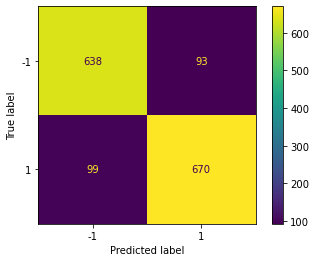

In [57]:
# # Using RBF Kernel to analyse performance
# from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import classification_report
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# model = SVC()
# (X_train, Y_train, X_test, Y_test) = extract_bag_of_words_train_test("movie_review_train.csv", "movie_review_test.csv")
# parameters = {'C':[0.1,1,10,20],'gamma':[0.001,0.1,1,10], 'kernel':['rbf']} 
# clf = GridSearchCV(model, parameters, cv=2, scoring='accuracy', n_jobs=-1, return_train_score=True, verbose=4)
# clf.fit(X_train,Y_train)
# y_pred=clf.predict(X_test)
# best_parameters=clf.best_params_
# train_acc=accuracy_score(Y_test,y_pred)
# cm = confusion_matrix(Y_test,y_pred, labels=clf.classes_)
# cmd = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
# cmd.plot()
# train_cf=cmd
# cv_acc=clf.best_score_
# print("Accuracy of RBF is ", train_acc)
# print("Best parameter is ", best_parameters)
# print("Best score is", cv_acc) 

In [58]:
# rbf_pred = pd.DataFrame(X_test.todense(),columns=feature_vector)
# rbf_pred['y_test'] = Y_test
# rbf_pred['y_pred'] = y_pred
# incorrect = rbf_pred.loc[rbf_pred['y_test'] != rbf_pred['y_pred']]

In [59]:
# data=pd.DataFrame(clf.cv_results_)
# display(data[['param_C','param_gamma','param_kernel','mean_test_score']])

,param_C,param_gamma,param_kernel,mean_test_score
0,0.1,0.001,rbf,0.5064
1,0.1,0.1,rbf,0.5064
2,0.1,1,rbf,0.5064
3,0.1,10,rbf,0.5064
4,1,0.001,rbf,0.5064
5,1,0.1,rbf,0.8150
6,1,1,rbf,0.8468
7,1,10,rbf,0.5076
8,10,0.001,rbf,0.5064
9,10,0.1,rbf,0.8388


In [60]:
# # Checking word length of missclassified reviews
# w_test_df = pd.read_csv('movie_review_test.csv')
# w_test_df['review'] = w_test_df['review'].apply(denoise_text)
# w_test_df['review'] = w_test_df['review'].apply(remove_special_characters)
# w_test_df['review'] = w_test_df['review'].apply(word_tokenize)
# w_test_df['review'] = w_test_df['review'].apply(simple_stemmer)
# w_test_df['review'] = w_test_df['review'].apply(remove_stopwords)
# w_test_df['sentiment'] = w_test_df['sentiment'].map({'positive': 1, 'negative': -1})

# # Creating a temporary data frame and storing incorrect reviews and sentiments
# w_clean_reviews=pd.DataFrame()
# w_clean_reviews['tokenized_review'] = w_test_df['review'].loc[incorrect.index].apply(word_tokenize)
# w_clean_reviews['sentiment'] = w_test_df['sentiment'].loc[incorrect.index]
# w_clean_reviews['length'] = w_clean_reviews['tokenized_review'].apply(len)

# display(w_clean_reviews)

# sorted_values=w_clean_reviews.groupby(by='length').count()
# sorted_values=sorted_values.loc[sorted_values['sentiment']>1]
# sorted_values=sorted_values.sort_values(by=['length'])
# print(sorted_values['sentiment'].value_counts())
# sorted_values.reset_index(inplace=True)
# display(sorted_values)

# #plot the no of pos and neg reviews word lengths

,tokenized_review,sentiment,length
2,"[rko, radio, pictur, made, real, classic, even...",1,145
3,"[transylvania, insignific, occasion, funni, ch...",-1,144
18,"[previous, wrote, love, titan, cri, end, mani,...",1,215
19,"[thi, movi, probabl, never, made, blip, radar,...",1,73
26,"[bought, thi, movi, thrift, store, month, befo...",-1,95
...,...,...,...
1469,"[best, show, track, stori, hand, human, contes...",1,140
1475,"[brain, wouldnt, die, consid, distast, sever, ...",1,299
1482,"[look, movi, doesnt, take, serious, haggard, m...",1,130
1484,"[thi, short, director, del, lord, last, onli, ...",-1,83


2    18
3    11
4     6
5     3
Name: sentiment, dtype: int64


,length,tokenized_review,sentiment
0,32,3,3
1,42,2,2
2,50,2,2
3,51,2,2
4,55,3,3
5,62,4,4
6,64,3,3
7,65,3,3
8,66,5,5
9,67,4,4


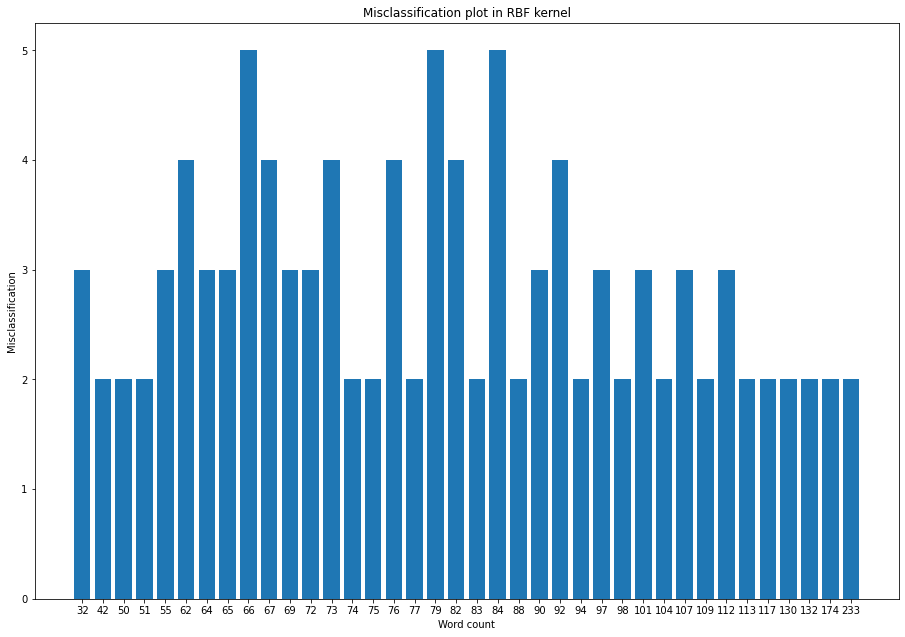

In [61]:
# import matplotlib.pyplot as plt

# fig = plt.figure()
# ax = fig.add_axes([0,0,2,2]) # main axes
# ax.bar(list(sorted_values.index),sorted_values['tokenized_review'])
# ax.set_xlabel('Word count')
# ax.set_ylabel('Misclassification')
# ax.set_title('Misclassification plot in RBF kernel')
# ax.set_xticks(list(sorted_values.index))
# ax.set_xticklabels(sorted_values['length'])
# plt.show()

## Polynomial Kernel

(5000, 39753) (1500, 39753)
(5000,) (1500,)
Fitting 2 folds for each of 12 candidates, totalling 24 fits
Accuracy is  0.8653333333333333
Best parameter is  {'C': 10, 'degree': 2, 'kernel': 'poly'}
Best score is 0.8293999999999999


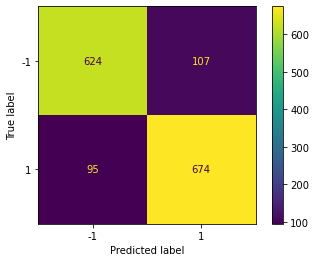

In [62]:
# model = SVC()
# (X_train, Y_train, X_test, Y_test) = extract_bag_of_words_train_test("movie_review_train.csv", "movie_review_test.csv")
# parameters = {'C':[0.1,1,10,20],'degree':[2,3,5], 'kernel':['poly']} 
# clf = GridSearchCV(model, parameters, cv=2, scoring='accuracy', n_jobs=-1, return_train_score=True, verbose=4)
# clf.fit(X_train,Y_train)
# y_pred=clf.predict(X_test)
# best_parameters=clf.best_params_
# train_acc=accuracy_score(Y_test,y_pred)
# cm = confusion_matrix(Y_test,y_pred, labels=clf.classes_)
# cmd = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
# cmd.plot()
# train_cf=cmd
# cv_acc=clf.best_score_
# print("Accuracy is ", train_acc)
# print("Best parameter is ", best_parameters)
# print("Best score is", cv_acc)

In [63]:
# poly_pred = pd.DataFrame(X_test.todense(),columns=feature_vector)
# poly_pred['y_test'] = Y_test
# poly_pred['y_pred'] = y_pred
# incorrect = poly_pred.loc[poly_pred['y_test'] != poly_pred['y_pred']]
# data=pd.DataFrame(clf.cv_results_)
# display(data[['param_C','param_degree','param_kernel','mean_test_score']])

,param_C,param_degree,param_kernel,mean_test_score
0,0.1,2,poly,0.5064
1,0.1,3,poly,0.5064
2,0.1,5,poly,0.5064
3,1,2,poly,0.8244
4,1,3,poly,0.7940
5,1,5,poly,0.5170
6,10,2,poly,0.8294
7,10,3,poly,0.7922
8,10,5,poly,0.5202
9,20,2,poly,0.8294


In [64]:
# # Checking word length of missclassified reviews
# w_test_df = pd.read_csv('movie_review_test.csv')
# w_test_df['review'] = w_test_df['review'].apply(denoise_text)
# w_test_df['review'] = w_test_df['review'].apply(remove_special_characters)
# w_test_df['review'] = w_test_df['review'].apply(word_tokenize)
# w_test_df['review'] = w_test_df['review'].apply(simple_stemmer)
# w_test_df['review'] = w_test_df['review'].apply(remove_stopwords)
# w_test_df['sentiment'] = w_test_df['sentiment'].map({'positive': 1, 'negative': -1})

# # Creating a temporary data frame and storing incorrect reviews and sentiments
# w_clean_reviews=pd.DataFrame()
# w_clean_reviews['tokenized_review'] = w_test_df['review'].loc[incorrect.index].apply(word_tokenize)
# w_clean_reviews['sentiment'] = w_test_df['sentiment'].loc[incorrect.index]
# w_clean_reviews['length'] = w_clean_reviews['tokenized_review'].apply(len)

# display(w_clean_reviews)

# sorted_values=w_clean_reviews.groupby(by='length').count()
# sorted_values=sorted_values.loc[sorted_values['sentiment']>1]
# sorted_values=sorted_values.sort_values(by=['length'])
# print(sorted_values['sentiment'].value_counts())
# sorted_values.reset_index(inplace=True)
# display(sorted_values)

,tokenized_review,sentiment,length
0,"[movi, everyon, thi, movi, top, lover, black, ...",1,91
2,"[rko, radio, pictur, made, real, classic, even...",1,145
3,"[transylvania, insignific, occasion, funni, ch...",-1,144
18,"[previous, wrote, love, titan, cri, end, mani,...",1,215
19,"[thi, movi, probabl, never, made, blip, radar,...",1,73
...,...,...,...
1475,"[brain, wouldnt, die, consid, distast, sever, ...",1,299
1482,"[look, movi, doesnt, take, serious, haggard, m...",1,130
1484,"[thi, short, director, del, lord, last, onli, ...",-1,83
1492,"[watch, thi, movi, showtim, quit, accid, actua...",1,60


2    23
3     8
4     5
5     5
6     1
Name: sentiment, dtype: int64


,length,tokenized_review,sentiment
0,32,3,3
1,34,2,2
2,42,2,2
3,53,2,2
4,55,2,2
5,56,3,3
6,60,4,4
7,62,5,5
8,64,4,4
9,65,2,2


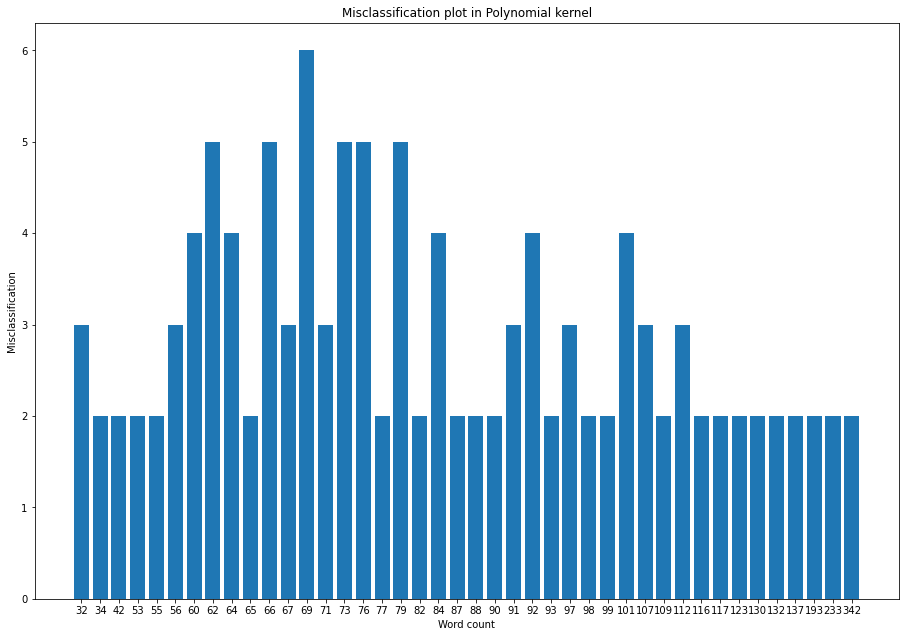

In [65]:
# import matplotlib.pyplot as plt

# fig = plt.figure()
# ax = fig.add_axes([0,0,2,2]) # main axes
# ax.bar(list(sorted_values.index),sorted_values['tokenized_review'])
# ax.set_xlabel('Word count')
# ax.set_ylabel('Misclassification')
# ax.set_title('Misclassification plot in Polynomial kernel')
# ax.set_xticks(list(sorted_values.index))
# ax.set_xticklabels(sorted_values['length'])
# plt.show()

## Linear Kernel

(5000, 39753) (1500, 39753)
(5000,) (1500,)
Fitting 2 folds for each of 4 candidates, totalling 8 fits
Accuracy is  0.8673333333333333
Best parameter is  {'C': 1, 'kernel': 'linear'}
Best score is 0.8475999999999999


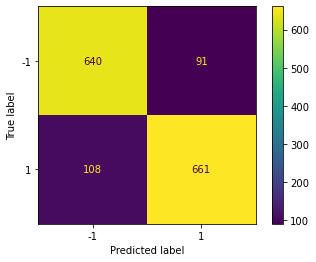

In [66]:
# model = SVC()
# (X_train, Y_train, X_test, Y_test) = extract_bag_of_words_train_test("movie_review_train.csv", "movie_review_test.csv")
# parameters = {'C':[0.1,1,10,20], 'kernel':['linear']}
# clf = GridSearchCV(model, parameters, cv=2, scoring='accuracy', n_jobs=-1, return_train_score=True, verbose=4)
# clf.fit(X_train,Y_train)
# y_pred=clf.predict(X_test)
# best_parameters=clf.best_params_
# train_acc=accuracy_score(Y_test,y_pred)
# cm = confusion_matrix(Y_test,y_pred, labels=clf.classes_)
# cmd = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
# cmd.plot()
# train_cf=cmd
# cv_acc=clf.best_score_
# print("Accuracy is ", train_acc)
# print("Best parameter is ", best_parameters)
# print("Best score is", cv_acc)

In [67]:
# poly_pred = pd.DataFrame(X_test.todense(),columns=feature_vector)
# poly_pred['y_test'] = Y_test
# poly_pred['y_pred'] = y_pred
# incorrect = poly_pred.loc[poly_pred['y_test'] != poly_pred['y_pred']]
# data=pd.DataFrame(clf.cv_results_)
# display(data[['param_C','param_kernel','mean_test_score']])

,param_C,param_kernel,mean_test_score
0,0.1,linear,0.7896
1,1,linear,0.8476
2,10,linear,0.8312
3,20,linear,0.8312


In [68]:
# # Checking word length of missclassified reviews
# w_test_df = pd.read_csv('movie_review_test.csv')
# w_test_df['review'] = w_test_df['review'].apply(denoise_text)
# w_test_df['review'] = w_test_df['review'].apply(remove_special_characters)
# w_test_df['review'] = w_test_df['review'].apply(word_tokenize)
# w_test_df['review'] = w_test_df['review'].apply(simple_stemmer)
# w_test_df['review'] = w_test_df['review'].apply(remove_stopwords)
# w_test_df['sentiment'] = w_test_df['sentiment'].map({'positive': 1, 'negative': -1})

# # Creating a temporary data frame and storing incorrect reviews and sentiments
# w_clean_reviews=pd.DataFrame()
# w_clean_reviews['tokenized_review'] = w_test_df['review'].loc[incorrect.index].apply(word_tokenize)
# w_clean_reviews['sentiment'] = w_test_df['sentiment'].loc[incorrect.index]
# w_clean_reviews['length'] = w_clean_reviews['tokenized_review'].apply(len)

# display(w_clean_reviews)

# sorted_values=w_clean_reviews.groupby(by='length').count()
# sorted_values=sorted_values.loc[sorted_values['sentiment']>1]
# sorted_values=sorted_values.sort_values(by=['length'])
# print(sorted_values['sentiment'].value_counts())
# sorted_values.reset_index(inplace=True)
# display(sorted_values)

,tokenized_review,sentiment,length
2,"[rko, radio, pictur, made, real, classic, even...",1,145
3,"[transylvania, insignific, occasion, funni, ch...",-1,144
18,"[previous, wrote, love, titan, cri, end, mani,...",1,215
19,"[thi, movi, probabl, never, made, blip, radar,...",1,73
22,"[thi, columbo, episod, probabl, note, director...",1,91
...,...,...,...
1469,"[best, show, track, stori, hand, human, contes...",1,140
1475,"[brain, wouldnt, die, consid, distast, sever, ...",1,299
1484,"[thi, short, director, del, lord, last, onli, ...",-1,83
1486,"[thi, movi, good, western, made, anthoni, mann...",1,80


2    21
3     8
4     8
5     2
6     1
Name: sentiment, dtype: int64


,length,tokenized_review,sentiment
0,32,2,2
1,42,2,2
2,50,2,2
3,51,2,2
4,55,2,2
5,62,3,3
6,64,4,4
7,65,2,2
8,66,5,5
9,67,5,5


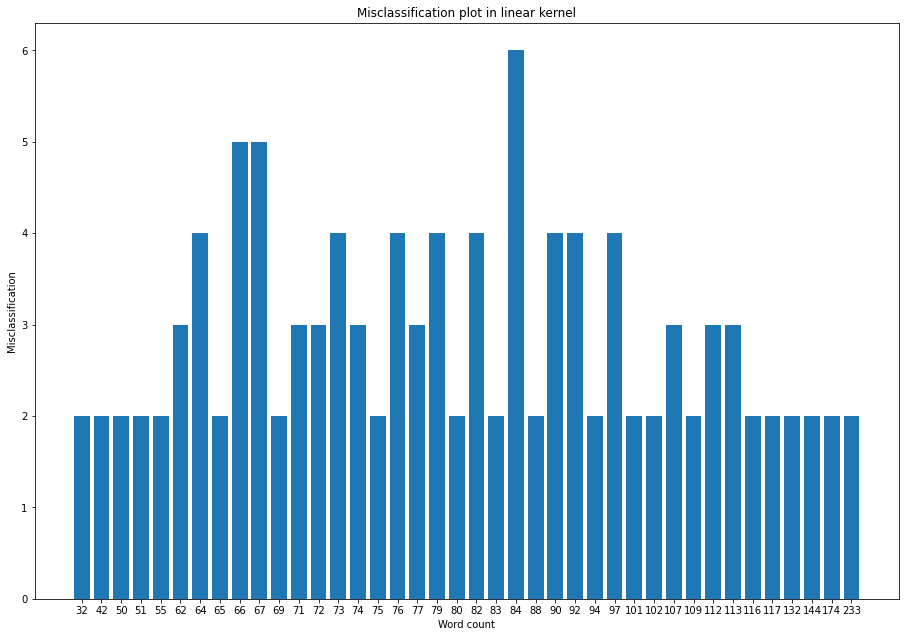

In [69]:
# import matplotlib.pyplot as plt

# fig = plt.figure()
# ax = fig.add_axes([0,0,2,2]) # main axes
# ax.bar(list(sorted_values.index),sorted_values['tokenized_review'])
# ax.set_xlabel('Word count')
# ax.set_ylabel('Misclassification')
# ax.set_title('Misclassification plot in linear kernel')
# ax.set_xticks(list(sorted_values.index))
# ax.set_xticklabels(sorted_values['length'])
# plt.show()

## Boosting classifier 


In [46]:
# Compute error rate, alpha and w
def calculate_error(y, y_pred, _weights):
    return (sum(_weights * (np.not_equal(y, y_pred)).astype(int)))/sum(_weights)

def estimate_alpha(error):
    return np.log((1 - error) / error)

def update_weights(_weights, alpha, y, y_pred):
    return _weights * np.exp(alpha * (np.not_equal(y, y_pred)).astype(int))

class BoostingClassifier:
    # You need to implement this classifier. 
    def __init__(self):
        import numpy as np
        self.alphas = []
        self.clf = []
        self.boosting_rounds = 1000
        self.training_errors = []
        self.prediction_errors = []
        #implement initialisation
        self.some_paramter=1
        
    def fit(self, X,y):
        from sklearn.tree import DecisionTreeClassifier
        import numpy as np
        self.alphas = [] 
        self.training_errors = []
        # Iterate over M weak classifiers
        for m in range(0, self.boosting_rounds):
            
            # Set weights for current boosting iteration
            if m == 0:
                _weights = np.ones(len(y)) * 1 / len(y)  # At m = 0, weights are all the same and equal to 1 / N
            else:
                # Updating _weights
                _weights = update_weights(_weights, alpha_m, y, y_pred)
            
            # (a) Fit weak classifier and predict labels
            
#             dt=DecisionTreeClassifier()
#             parameters=[{"criterion":["gini", "entropy"],"splitter":["best", "random"],"max_depth":[3,4,5,6]}]
#             clf = GridSearchCV(dt,param_grid=parameters,scoring="accuracy",cv=2, n_jobs=-1)
#             clf.fit(X_train,Y_train, sample_weight= _weights)
#             print(clf.best_params_)
#             y_pred=clf.predict(X)
#             print(accuracy_score(y, y_pred))

            clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)     # Stump: Two terminal-node classification tree
            clf.fit(X, y, sample_weight = _weights)
            y_pred = clf.predict(X)
            
            self.clf.append(clf) # Save to list of weak classifiers

            #Compute error
            error_m = calculate_error(y, y_pred, _weights)
            self.training_errors.append(error_m)

            #Compute alpha
            alpha_m = estimate_alpha(error_m)
            self.alphas.append(alpha_m)

        assert len(self.clf) == len(self.alphas)
        #implement training of the boosting classifier
        return 
    
    def predict(self, X):
        weak_predictors = pd.DataFrame(index = range(X.shape[0]), columns = range(self.boosting_rounds)) 

        # Predict class label for each weak classifier, weighted by alpha_m
        for m in range(self.boosting_rounds):
            y_pred_m = self.clf[m].predict(X) * self.alphas[m]
            weak_predictors.iloc[:,m] = y_pred_m

        # Calculate final predictions
        y_pred = (1 * np.sign(weak_predictors.T.sum())).astype(int)
        self.y_pred = y_pred
        return y_pred

In [ ]:
def test_func_boosting(dataset_train, dataset_test):
    from sklearn.metrics import accuracy_score    
    (X_train, Y_train, X_test, Y_test) = extract_bag_of_words_train_test(dataset_train, dataset_test)
    bc = BoostingClassifier()
    bc.fit(X_train, Y_train)
    Y_Pred = bc.predict(X_test)    
    acc = accuracy_score(Y_test, Y_Pred)
    return acc

In [ ]:
acc = test_func_boosting("movie_review_train.csv", "movie_review_test.csv")

In [ ]:
acc

## Boosting analysis

In [48]:
# num_class_cols = ['num_classifier', 'acccuracies']
# num_class_df = pd.DataFrame([], columns=num_class_cols)

# # classifiers_list = [i for i in range(2, 121, 2)]
# classifiers_list = [5, 20, 70, 200, 250, 300, 350, 400, 800]

# (X_train, Y_train, X_test, Y_test) = extract_bag_of_words_train_test("movie_review_train.csv", "movie_review_test.csv")

# for num_classifiers in classifiers_list:
        
#     for i in range(1):
        
#         df_scores = [num_classifiers]
#         print("##", i)
#         bc = BoostingClassifier(num_classifiers)
#         bc.fit(X_train, Y_train)
#         y_pred = bc.predict(X_test)
#         accuracy = accuracy_score(Y_test, y_pred)
#         df_scores.append(accuracy)
        
#         df_temp = pd.DataFrame([df_scores], columns=num_class_cols)
#         num_class_df = num_class_df.append(df_temp, ignore_index = True)    

#     print(num_classifiers, '> AVG accuracy: ', round(num_class_df[num_class_df['num_classifier']==num_classifiers].mean().values[1], 3))      



(5000, 39753) (1500, 39753)
(5000,) (1500,)
## 0
** 5
5 > AVG accuracy:  0.74
## 0
** 20
20 > AVG accuracy:  0.785
## 0
** 70
70 > AVG accuracy:  0.8
## 0
** 200
200 > AVG accuracy:  0.818
## 0
** 250
250 > AVG accuracy:  0.817
## 0
** 300
300 > AVG accuracy:  0.821
## 0
** 350
350 > AVG accuracy:  0.829
## 0
** 400
400 > AVG accuracy:  0.828
## 0
** 800
800 > AVG accuracy:  0.844


<AxesSubplot:xlabel='num_classifier', ylabel='acccuracies'>

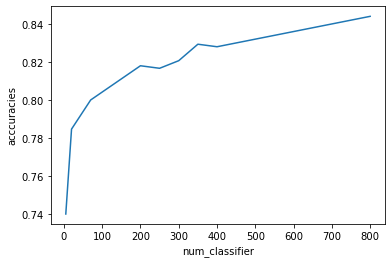

In [49]:
# import seaborn as sns

# sns.lineplot(data=num_class_df, x='num_classifier', y='acccuracies')

In [ ]:
# boosting_pred = pd.DataFrame(X_test.todense(),columns=feature_vector)
# boosting_pred['y_test'] = Y_test
# boosting_pred['y_pred'] = Y_Pred
# incorrect = boosting_pred.loc[boosting_pred['y_test'] != boosting_pred['y_pred']]

In [33]:
# # Checking word length of missclassified reviews
# w_test_df = pd.read_csv('movie_review_test.csv')
# w_test_df['review'] = w_test_df['review'].apply(denoise_text)
# w_test_df['review'] = w_test_df['review'].apply(remove_special_characters)
# w_test_df['review'] = w_test_df['review'].apply(word_tokenize)
# w_test_df['review'] = w_test_df['review'].apply(simple_stemmer)
# w_test_df['review'] = w_test_df['review'].apply(remove_stopwords)
# w_test_df['sentiment'] = w_test_df['sentiment'].map({'positive': 1, 'negative': -1})

# # Creating a temporary data frame and storing incorrect reviews and sentiments
# w_clean_reviews=pd.DataFrame()
# w_clean_reviews['tokenized_review'] = w_test_df['review'].loc[incorrect.index].apply(word_tokenize)
# w_clean_reviews['sentiment'] = w_test_df['sentiment'].loc[incorrect.index]
# w_clean_reviews['length'] = w_clean_reviews['tokenized_review'].apply(len)


# sorted_values=w_clean_reviews.groupby(by='length').count()
# sorted_values=sorted_values.loc[sorted_values['sentiment']>1]
# sorted_values=sorted_values.sort_values(by=['length'])
# print(sorted_values['sentiment'].value_counts())
# sorted_values.reset_index(inplace=True)

,tokenized_review,sentiment,length
0,"[movi, everyon, thi, movi, top, lover, black, ...",1,91
1,"[thi, film, typic, hollywood, fare, though, pi...",1,52
15,"[let, clear, hate, kind, movi, like, anyth, pr...",-1,137
18,"[previous, wrote, love, titan, cri, end, mani,...",1,215
26,"[bought, thi, movi, thrift, store, month, befo...",-1,95
...,...,...,...
1482,"[look, movi, doesnt, take, serious, haggard, m...",1,130
1484,"[thi, short, director, del, lord, last, onli, ...",-1,83
1486,"[thi, movi, good, western, made, anthoni, mann...",1,80
1494,"[new, thi, bear, pleas, big, fan, surfac, thou...",1,96


2    30
3    14
4     6
5     3
6     1
Name: sentiment, dtype: int64


,length,tokenized_review,sentiment
0,32,2,2
1,34,2,2
2,44,2,2
3,50,3,3
4,51,2,2
5,52,2,2
6,53,2,2
7,55,5,5
8,56,2,2
9,59,3,3


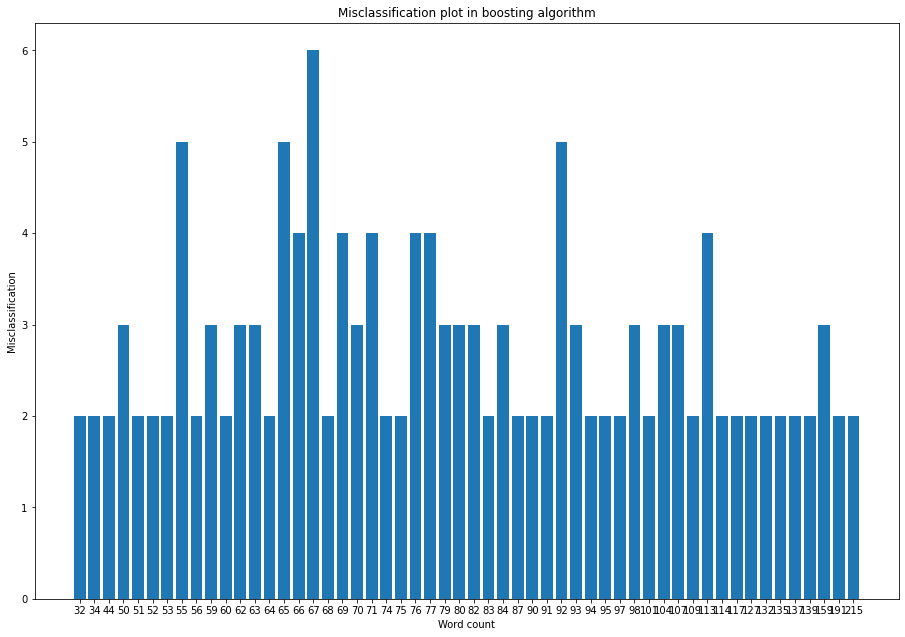

In [34]:
# import matplotlib.pyplot as plt

# fig = plt.figure()
# ax = fig.add_axes([0,0,2,2]) # main axes
# ax.bar(list(sorted_values.index),sorted_values['tokenized_review'])
# ax.set_xlabel('Word count')
# ax.set_ylabel('Misclassification')
# ax.set_title('Misclassification plot in boosting algorithm')
# ax.set_xticks(list(sorted_values.index))
# ax.set_xticklabels(sorted_values['length'])
# plt.show()